## E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

#### Dataset downloading and preprocessing

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Training split , dev/validation split, test split
# 80/10/10
# build the dataset
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

#### Training

In [5]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [390]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility 
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, W2, b1, b2]
# Num of parameters
sum(p.nelement() for p in parameters)

11897

In [391]:
for p in parameters:
  p.requires_grad = True

In [392]:
stepi = []
lossi = []

In [393]:
lr_init = 2.0
reduction_factor = 2.0
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # Forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Updating the weights 
  if i%25000 == 0:

    lr_init = lr_init/ reduction_factor
    print("new lr: ", lr_init, i)
  lr = lr_init
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

new lr:  1.0 0
new lr:  0.5 25000
new lr:  0.25 50000
new lr:  0.125 75000
new lr:  0.0625 100000
new lr:  0.03125 125000
new lr:  0.015625 150000
new lr:  0.0078125 175000
2.036695957183838


In [394]:
# Evaluating on the whole training dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1601, grad_fn=<NllLossBackward0>)

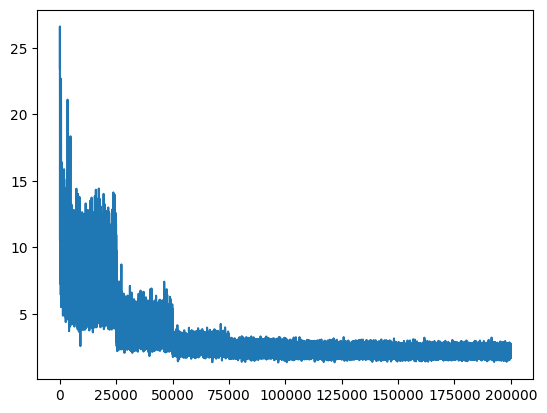

In [395]:
plt.plot(stepi, lossi)

#### Evaluating using dev split

In [396]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1992, grad_fn=<NllLossBackward0>)

## - E02: I was not careful with the intialization of the network in this video

### (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [409]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility 
C = torch.zeros((27, 10))
W1 = torch.zeros((30, 200))
b1 = torch.zeros(200)
W2 = torch.zeros((200, 27))
b2 = torch.zeros(27)
parameters = [C, W1, W2, b1, b2]
# Num of parameters
sum(p.nelement() for p in parameters)

11897

In [410]:
for p in parameters:
  p.requires_grad = True

In [411]:
stepi = []
lossi = []

In [412]:
lr_init = 2.0
reduction_factor = 2.0
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # Forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Updating the weights 
  if i%2500 == 0:

    lr_init = lr_init/ reduction_factor
    print("new lr: ", lr_init, i)
  lr = lr_init
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

new lr:  1.0 0
new lr:  0.5 2500
new lr:  0.25 5000
new lr:  0.125 7500
new lr:  0.0625 10000
new lr:  0.03125 12500
new lr:  0.015625 15000
new lr:  0.0078125 17500
2.620361089706421
